In [15]:
# -*- coding: utf-8 -*-
#  Copyright 2019 - 2022 United Kingdom Research and Innovation
#  Copyright 2019 - 2022 The University of Manchester
#  Copyright 2019 - 2022 The University of Bath
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Claire Delplancke (University of Bath)
#                   Evangelos Papoutsellis (UKRI-STFC)
#                   Gemma Fardell (UKRI-STFC)
#                   Laura Murgatroyd (UKRI-STFC)     



In [16]:
# Import libraries
  
from cil.optimisation.algorithms import PDHG, SPDHG
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.optimisation.functions import LeastSquares
from cil.optimisation.algorithms import GD


from cil.io import ZEISSDataReader
 
from cil.processors import Slicer, Binner, TransmissionAbsorptionConverter
 
from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.ccpi_regularisation.functions import FGP_TV
 
from cil.utilities.display import show2D
from cil.utilities.jupyter import islicer
 
from SGFunction import SGFunction
 
import numpy as np
import matplotlib.pyplot as plt
import os

# Data information

In this demo, we use the **Walnut** found in [Jørgensen_et_all](https://zenodo.org/record/4822516#.YLXyAJMzZp8). In total, there are 6 individual micro Computed Tomography datasets in the native Zeiss TXRM/TXM format. The six datasets were acquired at the 3D Imaging Center at Technical University of Denmark in 2014 (HDTomo3D in 2016) as part of the ERC-funded project High-Definition Tomography (HDTomo) headed by Prof. Per Christian Hansen. 

This example requires the dataset walnut.zip from https://zenodo.org/record/4822516 :

    https://zenodo.org/record/4822516/files/walnut.zip

If running locally please download the data and update the `path` variable below.

In [17]:
path = '../../data/walnut/valnut'

In [18]:
reader = ZEISSDataReader()
filename = "valnut_tomo-A.txrm"
reader.set_up(file_name=filename)
data3D = reader.read()

# reorder data to match default order for Astra/Tigre operator
data3D.reorder('astra')

# Get Image and Acquisition geometries
ag3D = data3D.geometry
ig3D = ag3D.get_ImageGeometry()

# Extract vertical slice
data2D = data3D.get_slice(vertical='centre')

# Select every 10 angles
sliced_data = Slicer(roi={'angle':(0,1601,10)})(data2D)

# Reduce background regions
binned_data = Binner(roi={'horizontal':(120,-120,2)})(sliced_data)

# Create absorption data 
data = TransmissionAbsorptionConverter()(binned_data) 

# Remove circular artifacts
data -= np.mean(data.as_array()[80:100,0:30])

# Get Image and Acquisition geometries for one slice
ag2D = data.geometry
ag2D.set_angles(ag2D.angles, initial_angle=0.2, angle_unit='radian')
ig2D = ag2D.get_ImageGeometry()

A = ProjectionOperator(ig2D, ag2D, device = "gpu")

We need to define the following:

- The operator $K=(K_1,\dots,K_n)$.
- The functions $F=(F_1,\dots,F_N)$ and $G$.
- The maximum number of iterations



In [19]:
# Define number of subsets
n_subsets = 20

# Initialize the lists containing the F_i's and A_i's
f_subsets = []
A_subsets = []

# Define F_i's and A_i's
for i in range(n_subsets):
    # Total number of angles
    n_angles = len(ag2D.angles)
    # Divide the data into subsets
    data_subset = Slicer(roi = {'angle' : (i,n_angles,n_subsets)})(data)
    
    # Define A_i and put into list 
    ageom_subset = data_subset.geometry
    Ai = ProjectionOperator(ig2D, ageom_subset)
    A_subsets.append(Ai)
    # Define F_i and put into list
    fi = LeastSquares(Ai, b=data_subset)
    f_subsets.append(fi)


In [20]:


class Sampling():
    def __init__(self, num_subsets, prob=None, seed=99):
        self.num_subsets=num_subsets
        np.random.seed(seed)

        if prob==None:
            self.prob = [1/self.num_subsets] * self.num_subsets
        else:
            self.prob=prob
    def next(self):
        
            return int(np.random.choice(self.num_subsets, 1, p=self.prob))
sampler=Sampling(n_subsets)

Dask is not installed.
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.38039e+04
      100       1000         0.028          4.44989e+01
      200       1000         0.027          4.07130e+01
      300       1000         0.022          3.95771e+01
      400       1000         0.019          3.94965e+01
      500       1000         0.018          3.92958e+01
      600       1000         0.017          3.89547e+01
      700       1000         0.017          3.88912e+01
      800       1000         0.019          3.87862e+01
      900       1000         0.019          3.86670e+01
     1000       1000         0.018          3.89482e+01
-------------------------------------------------------
     1000       1000         0.018          3.89482e+01
Stop criterion has been reached.



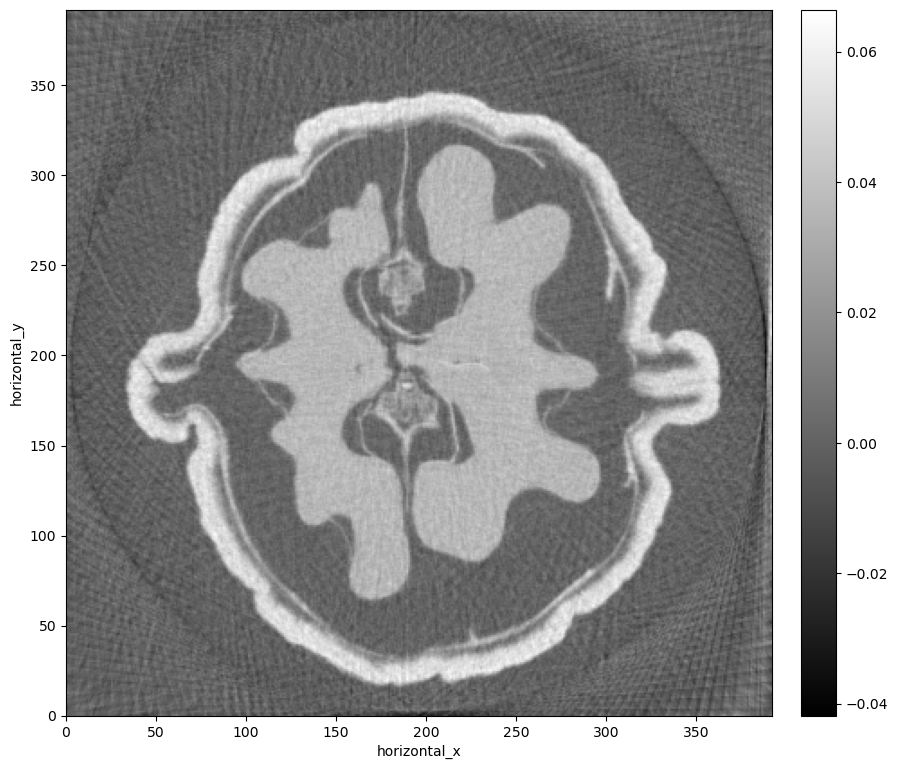

In [21]:
stochastic_objective=SGFunction(f_subsets,sampler)
mySGD_LS = GD(initial=ig2D.allocate(0), 
             objective_function=stochastic_objective, 
             step_size=0.001, 
             max_iteration=1000, 
             update_objective_interval=100)
mySGD_LS.run(1000, verbose=1)

show2D(mySGD_LS.solution)

Dask is not installed.
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.38039e+04
      100       1000         0.011          4.39259e+01
      200       1000         0.011          4.02738e+01
      300       1000         0.014          3.97689e+01
      400       1000         0.017          3.94480e+01
      500       1000         0.017          3.93345e+01
      600       1000         0.016          3.89108e+01
      700       1000         0.016          4.04457e+01
      800       1000         0.015          3.90482e+01
      900       1000         0.015          3.88493e+01
     1000       1000         0.016          3.87953e+01
-------------------------------------------------------
     1000       1000         0.016          3.87953e+01
Stop criterion has been reached.



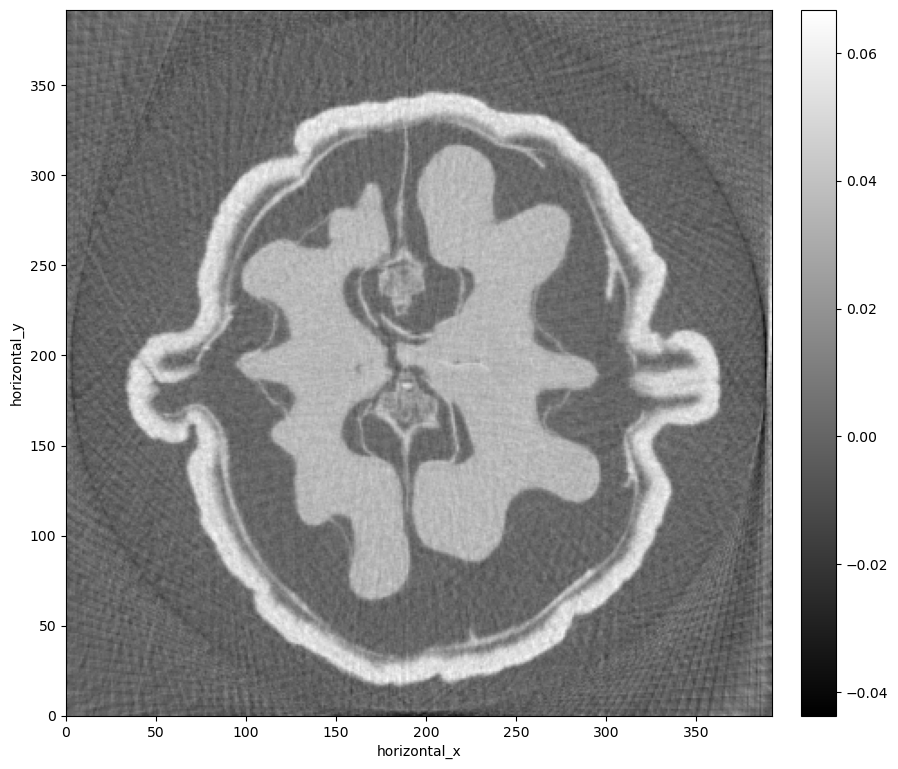

In [22]:
stochastic_objective=SGFunction(f_subsets,sampler)
mySGD_LS = GD(initial=ig2D.allocate(0), 
             objective_function=stochastic_objective, 
             step_size=0.001, 
             max_iteration=1000, 
             update_objective_interval=100)
mySGD_LS.run(1000, verbose=1)

show2D(mySGD_LS.solution)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.38039e+04


      100       1000         0.030          4.34737e+01
      200       1000         0.023          3.99915e+01
      300       1000         0.021          3.92955e+01
      400       1000         0.024          3.89863e+01
      500       1000         0.025          3.87991e+01
      600       1000         0.024          3.86670e+01
      700       1000         0.023          3.85653e+01
      800       1000         0.023          3.84827e+01
      900       1000         0.025          3.84133e+01
     1000       1000         0.024          3.83534e+01
-------------------------------------------------------
     1000       1000         0.024          3.83534e+01
Stop criterion has been reached.



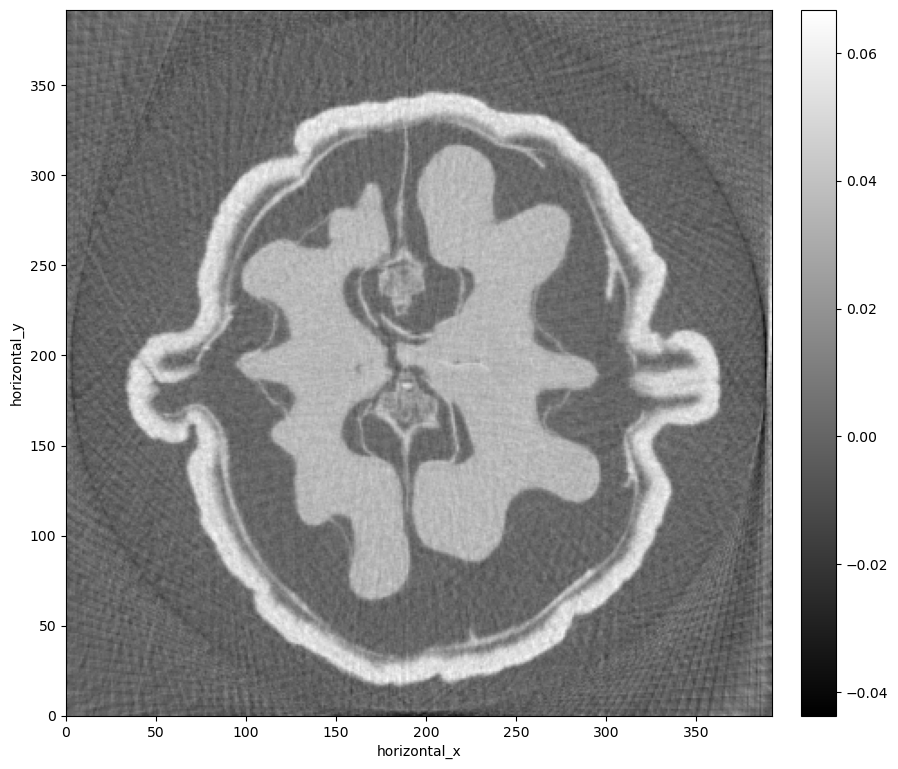

In [23]:
f = LeastSquares(A, b=data)
myGD_LS = GD(initial=ig2D.allocate(0), 
             objective_function=f, 
             step_size=0.001, 
             max_iteration=1000, 
             update_objective_interval=100)
myGD_LS.run(1000, verbose=1)

show2D(mySGD_LS.solution)